In [3]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point 

from random import *

%qtconsole

In [4]:
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\processed\\'
docs_img_dir = 'C:\\Users\\bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\docs\\img\\'

## Initial Data Exploration

In [55]:
df_train_val = pd.read_csv(data_raw_dir + 'training_values.csv')
df_test_val = pd.read_csv(data_raw_dir + 'test_values.csv')
df_train_lab = pd.read_csv(data_raw_dir + 'training_labels.csv')

df_comp_val = pd.read_csv(data_interim_dir+'comp_val_gps_corrected.csv',index_col=0).reset_index(drop=True)

print(df_comp_val.shape)
print(df_comp_val.columns)

df_comp_val.head(2)

(74228, 40)
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


#### Create Label Definition Dictionary

In [6]:
label_list = ['amount_tsh - Total static head (amount water available to waterpoint)',
'date_recorded - The date the row was entered',
'funder - Who funded the well',
'gps_height - Altitude of the well',
'installer - Organization that installed the well',
'longitude - GPS coordinate',
'latitude - GPS coordinate',
'wpt_name - Name of the waterpoint if there is one',
'num_private - ',
'basin - Geographic water basin',
'subvillage - Geographic location',
'region - Geographic location',
'region_code - Geographic location (coded)',
'district_code - Geographic location (coded)',
'lga - Geographic location',
'ward - Geographic location',
'population - Population around the well',
'public_meeting - True/False',
'recorded_by - Group entering this row of data',
'scheme_management - Who operates the waterpoint',
'scheme_name - Who operates the waterpoint',
'permit - If the waterpoint is permitted',
'construction_year - Year the waterpoint was constructed',
'extraction_type - The kind of extraction the waterpoint uses',
'extraction_type_group - The kind of extraction the waterpoint uses',
'extraction_type_class - The kind of extraction the waterpoint uses',
'management - How the waterpoint is managed',
'management_group - How the waterpoint is managed',
'payment - What the water costs',
'payment_type - What the water costs',
'water_quality - The quality of the water',
'quality_group - The quality of the water',
'quantity - The quantity of water',
'quantity_group - The quantity of water',
'source - The source of the water',
'source_type - The source of the water',
'source_class - The source of the water',
'waterpoint_type - The kind of waterpoint',
'waterpoint_type_group - The kind of waterpoint']

label_list = [x.split(' - ') for x in label_list]
label_desc = [y for (x,y) in label_list]
label_list = [x for (x,y) in label_list]

label_dict = {}
label_dict = dict(zip(label_list,label_desc))

In [7]:
var = 'id'
def explore_data(var,slice=-len(df_comp_val[var].unique())):
    print(label_dict[var])
    print(df_comp_val[var].dtype)
    print(df_comp_val[var].unique()[slice:])
    print(str(len(df_comp_val[var].unique())) + ' unique values')
    print(str(df_comp_val[var].isna().sum())+' missing or null values')

### Missing Data

In [8]:
df_comp_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74228 entries, 0 to 74227
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74228 non-null  int64  
 1   amount_tsh             74228 non-null  float64
 2   date_recorded          74228 non-null  object 
 3   funder                 69724 non-null  object 
 4   gps_height             74228 non-null  int64  
 5   installer              69696 non-null  object 
 6   longitude              74228 non-null  float64
 7   latitude               74228 non-null  float64
 8   wpt_name               74228 non-null  object 
 9   num_private            74228 non-null  int64  
 10  basin                  74228 non-null  object 
 11  subvillage             73758 non-null  object 
 12  region                 74228 non-null  object 
 13  region_code            74228 non-null  int64  
 14  district_code          74228 non-null  int64  
 15  lg

#### id

In [9]:
var='id'

print(df_comp_val[var].unique())

# type int - index / id value - Good

df_comp_val[var].value_counts(sort=True)[:2]

# no duplicates - no error values

[69572  8776 34310 ... 28749 33492 68707]


0        1
42238    1
Name: id, dtype: int64

#### amount_tsh

In [10]:
var = 'amount_tsh'
explore_data(var,-5)

# type float - some decimal values it looks like - Good

df_comp_val[var].value_counts(sort=True)[:3]

Total static head (amount water available to waterpoint)
float64
[5.90e+01 3.50e+04 3.00e+00 2.55e+03 5.00e-01]
102 unique values
0 missing or null values


0.0         52027
500.0        3874
50.0         3103
1000.0       1858
20.0         1812
            ...  
70000.0         2
53.0            1
250000.0        1
900.0           1
3.0             1
Name: amount_tsh, Length: 84, dtype: int64

70% of data read zero, could be an bad column but will keep for now.

#### date_recorded

In [11]:
var = 'date_recorded'
explore_data(var,-5)

# type object - change to datetime

df_comp_val[var].value_counts(sort=True)[:5]


The date the row was entered
object
['2004-01-12' '2011-09-07' '2004-12-03' '2011-09-22' '2004-01-09']
369 unique values
0 missing or null values


2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
Name: date_recorded, dtype: int64

In [12]:
df_comp_val[var] = pd.to_datetime(df_comp_val[var],format='%Y-%m-%d')

# type datetime - Good

#### funder

In [13]:
var = 'funder'
explore_data(var,-5)

# type string / object - lots of values - Good

print(df_comp_val[var].value_counts(sort=True)[:20])

# 0 values - unknown?

print(str(((df_comp_val[var].value_counts()==1).sum()))+' values have 1 instance')

# lots of potential error in input (romam catholic church vs. Roman Catholic Church, etc.)

Who funded the well
object
['Canaco' 'Banane' 'Nyamigogo' 'Village Fou' 'Velem']
2141 unique values
4504 missing or null values
Government Of Tanzania    11292
Danida                     3907
Hesawa                     2771
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1322
Tasaf                      1136
Dhv                        1065
District Council           1037
Private Individual         1034
Dwsp                       1012
0                           980
Norad                       949
Germany Republi             765
Water                       739
Tcrs                        735
Ministry Of Water           728
Dwe                         605
Name: funder, dtype: int64
1129 values have 1 instance


In [14]:
list_one = df_comp_val[var].value_counts()[df_comp_val[var].value_counts()==1].index.to_list()

for idx in df_comp_val[df_comp_val[var].isin(list_one)].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

for idx in df_comp_val[(df_comp_val[var]=='0') | (df_comp_val[var].isnull())].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

In [15]:
# type object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### installer

In [16]:
var = 'installer'
explore_data(var,-5)

# type string / object - lots of values - Good

print(df_comp_val[var].value_counts(sort=True)[:20])

# 0 values - unknown?

print(str(((df_comp_val[var].value_counts()==1).sum()))+' values have 1 instance')

Organization that installed the well
object
['Mombia' 'CANACO' 'Banane' 'MAJIJA CHARLES' 'Central government/TLC']
2410 unique values
4532 missing or null values
DWE                   21739
Government             2275
RWE                    1498
Commu                  1347
DANIDA                 1305
KKKT                   1120
Hesawa                 1070
0                       980
TCRS                    887
CES                     765
Central government      764
DANID                   690
Community               687
HESAWA                  679
District Council        663
World vision            517
TASAF                   504
LGA                     501
WEDECO                  496
District council        490
Name: installer, dtype: int64
1244 values have 1 instance


In [17]:
list_one = df_comp_val[var].value_counts()[df_comp_val[var].value_counts()==1].index.to_list()

for idx in df_comp_val[df_comp_val[var].isin(list_one)].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

for idx in df_comp_val[(df_comp_val[var]=='0') | (df_comp_val[var].isnull())].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

In [18]:
# type object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### longitude

In [19]:
var = 'longitude'
explore_data(var,-5)

# type float - Good

df_comp_val[var].value_counts(sort=True)

GPS coordinate
float64
[38.85266884 37.45163346 34.7398045  35.43273168 34.76505448]
71937 unique values
0 missing or null values


34.211478    135
34.149346    100
34.167443     94
32.278174     86
33.995811     85
            ... 
36.681688      1
33.319196      1
38.348075      1
37.806786      1
35.164770      1
Name: longitude, Length: 71937, dtype: int64

#### latitude

In [20]:
var = 'latitude'
explore_data(var,-5)

# type float - Good

df_comp_val[var].value_counts(sort=True)

GPS coordinate
float64
[ -6.58284095  -5.35042799  -4.58558667 -10.58415869 -11.22601197]
71936 unique values
0 missing or null values


-2.863661     135
-2.754004     100
-2.656559      94
-2.877503      86
-2.748329      85
             ... 
-4.790095       1
-3.669355       1
-3.167823       1
-1.844915       1
-10.772897      1
Name: latitude, Length: 71936, dtype: int64

#### wpt_name

In [21]:
var = 'wpt_name'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True)

Name of the waterpoint if there is one
object
['Mwandami' 'Ikanayugu' 'Kwambwezi' 'Bonde La Mkondoa' 'Kwa Mzee Chagala']
45672 unique values
0 missing or null values


none             4440
Shuleni          2183
Zahanati         1034
Msikitini         646
Kanisani          390
                 ... 
Mafuleta            1
Kwa Mzee Tani       1
Saki Simwanza       1
Mzrmbe              1
Mzeengoma           1
Name: wpt_name, Length: 45672, dtype: int64

In [22]:
# too many values to be a useful feature
df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### num_private

In [23]:
var = 'num_private'
explore_data(var,-5)

# type int - very few unique values - not sure what it means so hard to interpret

df_comp_val[var].value_counts(sort=True,normalize=True)[:3]


int64
[  55 1402  669   13  420]
68 unique values
0 missing or null values


0    0.987188
1    0.001266
6    0.001239
Name: num_private, dtype: float64

In [24]:
# 98% of data with value 0 - drop
df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### basin

In [25]:
var = 'basin'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True,normalize=True)

Geographic water basin
object
['Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
9 unique values
0 missing or null values


Lake Victoria              0.173102
Pangani                    0.150119
Rufiji                     0.134545
Internal                   0.129897
Lake Tanganyika            0.108477
Wami / Ruvu                0.102077
Lake Nyasa                 0.085305
Ruvuma / Southern Coast    0.075268
Lake Rukwa                 0.041211
Name: basin, dtype: float64

In [26]:
# type object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### subvillage

In [27]:
var = 'subvillage'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True)

# many unique values

Geographic location
object
['Ilege' 'Mbwenga' 'Kabita' 'Nyamalonda' 'Kosoro']
21414 unique values
470 missing or null values


Shuleni       646
Majengo       631
Madukani      629
Kati          467
Mtakuja       322
             ... 
Esmiti          1
Mlengasemo      1
Kijenge         1
Mitondo A       1
Angalia         1
Name: subvillage, Length: 21413, dtype: int64

In [28]:
list_one_subvillage = df_comp_val[var].value_counts()[df_comp_val[var].value_counts()==1].index.to_list()

for idx in df_comp_val[df_comp_val[var].isin(list_one_subvillage)].index.to_list():
    df_comp_val.loc[idx,var] = 'other'
    
for idx in df_comp_val[df_comp_val[var].isnull()].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

In [29]:
# many unique values - already have many location features
df_comp_val = df_comp_val.drop(labels=[var],axis=1)

### Region

#### region

In [30]:
var = 'region'
explore_data(var,-5)

Geographic location
object
['Geita' 'Morogoro' 'Songwe' 'Dar es Salaam' 'Katavi']
26 unique values
0 missing or null values


In [31]:
# type object - few unique values - to categorical, corrected by GPS.

df_comp_val[var] = df_comp_val[var].astype('category')

#### region_code

In [32]:
var = 'region_code'
explore_data(var,-5)

for rc in df_comp_val['region_code'].unique()[:2]:
    print(df_comp_val[['region','region_code']][df_comp_val.region_code == rc].drop_duplicates())


Geographic location (coded)
int64
[99 24  9  8 40]
27 unique values
0 missing or null values
          region  region_code
0         Njombe           11
38        Iringa           11
4883       Mbeya           11
15904     Simiyu           11
19767  Shinyanga           11
22004   Morogoro           11
       region  region_code
1        Mara           20
71712  Simiyu           20


Values are inconsistent between regions, and region already corrected with GPS coordinates. Drop region_code.

In [33]:
df_comp_val = df_comp_val.drop(labels=['region_code'],axis=1)

#### district_code

In [34]:
var = 'district_code'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True)[:3]

for rc in df_comp_val[var].unique()[:1]:
    print(df_comp_val[['region','lga',var]][df_comp_val[var] == rc].drop_duplicates())


Geographic location (coded)
int64
[30 13  0 80 67]
20 unique values
0 missing or null values
            region             lga  district_code
0           Njombe          Ludewa              5
11          Ruvuma        Namtumbo              5
79           Geita          Mbogwe              5
85          Mwanza       Sengerema              5
89          Dodoma    Dodoma Urban              5
104    Kilimanjaro             Hai              5
119        Manyara          Kiteto              5
142         Tabora         Sikonge              5
213         Songwe           Ileje              5
290       Morogoro         Mvomero              5
320         Mtwara    Mtwara Urban              5
361          Tanga         Kilindi              5
465         Arusha      Ngorongoro              5
515          Tanga         Pangani              5
693          Geita         Bukombe              5
2621      Morogoro        Morogoro              5
3609        Dodoma          Kongwa              5
3788   

Values are inconsistent between region / lga, and region already corrected with GPS coordinates - candidate to drop the feature if no modelling value.

#### lga

In [35]:
var = 'lga'
explore_data(var,-5)


Geographic location
object
['Masasi  Township Authority' 'Mbeya Urban' 'Tunduma' 'Bukoba Rural'
 'Babati Urban']
159 unique values
0 missing or null values


In [36]:
# type string / object - few unique values - to categorical

df_comp_val.lga = df_comp_val.lga.replace('Kigoma  Urban','Kigoma Urban')
df_comp_val.lga = df_comp_val.lga.replace('Bukoba Rural','Bukoba')

df_comp_val[var] = df_comp_val[var].astype('category')

#### ward

In [37]:
var = 'ward'
explore_data(var,-5)

Geographic location
object
['Sange' "Kang'ata" "Gorong'a" 'Mdabulo' 'Mwalugulu']
2097 unique values
0 missing or null values


In [38]:
# type string / object - unique categorical values - to categorical

df_comp_val[var] = df_comp_val[var].astype('category')

#### population

In [39]:
var = 'population'
explore_data(var,-5)

print(df_comp_val[var].value_counts().sort_index()[:3])

Population around the well
int64
[2554 7600 1869 1542 2960]
1128 unique values
0 missing or null values
0    26812
1     8782
2        9
Name: population, dtype: int64


Zero values could have significance or insignificance. Potential to revisit if no value in modelling.

#### public_meeting

In [40]:
var = 'public_meeting'
explore_data(var,-5)

# type object - to Boolean
# change NaN to False

for idx in df_comp_val[df_comp_val[var].isna()].index.tolist():
    df_comp_val.loc[idx,var] = False

df_comp_val[var] = df_comp_val[var].astype(int)

True/False
object
[True nan False]
3 unique values
4155 missing or null values


In [41]:
df_comp_val[var].value_counts(normalize=True)

1    0.85853
0    0.14147
Name: public_meeting, dtype: float64

#### recorded_by

In [42]:
var = 'recorded_by'
explore_data(var,-5)

Group entering this row of data
object
['GeoData Consultants Ltd']
1 unique values
0 missing or null values


In [43]:
# one value - can delete this column.
df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### scheme_management

In [44]:
var = 'scheme_management'
explore_data(var,-5)

df_comp_val[var].value_counts()

Who operates the waterpoint
object
['Company' 'Parastatal' 'Trust' 'SWC' 'None']
13 unique values
4846 missing or null values


VWC                 45895
WUG                  6496
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [46]:
df_comp_val[var] = df_comp_val[var].fillna('unknown')

VWC                 45895
WUG                  6496
unknown              4846
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

#### scheme_name

In [49]:
var = 'scheme_name'
explore_data(var,-5)

df_comp_val[var].value_counts()

Who operates the waterpoint
object
['Mradi wa maji wa Buhanda' 'LumeyaKalebezo Nyehunge Water project'
 'Grumeti' 'BL Vetenary' 'MIGA']
2866 unique values
35241 missing or null values


K                858
None             794
Borehole         704
Chalinze wate    501
M                490
                ... 
Nguj               1
BL Nsherehehe      1
Tina               1
Mafi Mountain      1
Jaduwaso           1
Name: scheme_name, Length: 2865, dtype: int64

In [50]:
df_comp_val = df_comp_val.drop(labels=[var],axis=1)

Significant number of unique values - LOTS of missing values. Best thing to do is to drop column.

#### permit

In [51]:
var = 'permit'
explore_data(var,-5)

df_comp_val[var].value_counts()

If the waterpoint is permitted
object
[False True nan]
3 unique values
3793 missing or null values


True     48584
False    21851
Name: permit, dtype: int64

In [52]:
for idx in df_comp_val[df_comp_val[var].isna()].index.tolist():
    df_comp_val.loc[idx,var] = False

df_comp_val[var] = df_comp_val[var].astype(int)

#### construction_year

Year the waterpoint was constructed
int64
[1969 1981 1964 1966 1965]
55 unique values
0 missing or null values
0       25947
2010     3314
2008     3243
Name: construction_year, dtype: int64


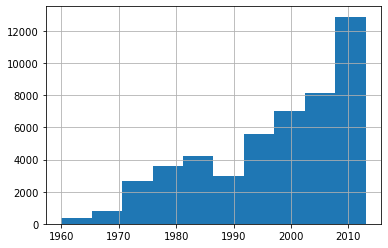

In [49]:
var = 'construction_year'
explore_data(var,-5)

# type int - to datetime

print(df_comp_val[var].value_counts()[:3])

# nearly 1/3 of values are zero (N/A), most likely not a useful column without more data

df_comp_val[df_comp_val[var]!=0].construction_year.hist();

In [52]:
for id in df_comp_val[df_comp_val[var]==0].id .tolist()

[4,
 6,
 7,
 8,
 9,
 12,
 14,
 21,
 27,
 30,
 34,
 36,
 37,
 45,
 47,
 52,
 53,
 54,
 59,
 67,
 71,
 72,
 75,
 79,
 83,
 85,
 87,
 89,
 94,
 97,
 99,
 106,
 107,
 109,
 112,
 113,
 114,
 115,
 121,
 122,
 124,
 125,
 128,
 129,
 130,
 131,
 132,
 133,
 136,
 138,
 139,
 140,
 142,
 145,
 146,
 149,
 151,
 156,
 157,
 158,
 164,
 166,
 168,
 177,
 178,
 181,
 184,
 186,
 187,
 188,
 189,
 192,
 199,
 200,
 204,
 205,
 206,
 211,
 213,
 215,
 217,
 219,
 228,
 229,
 235,
 236,
 238,
 239,
 241,
 242,
 245,
 253,
 255,
 256,
 260,
 262,
 263,
 264,
 268,
 270,
 271,
 272,
 273,
 282,
 285,
 287,
 295,
 298,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 309,
 311,
 312,
 313,
 319,
 320,
 321,
 322,
 323,
 324,
 326,
 329,
 332,
 333,
 334,
 336,
 340,
 342,
 346,
 352,
 355,
 357,
 358,
 360,
 363,
 368,
 370,
 377,
 379,
 386,
 387,
 390,
 394,
 397,
 400,
 403,
 404,
 405,
 406,
 411,
 413,
 416,
 423,
 427,
 429,
 431,
 433,
 434,
 437,
 439,
 443,
 445,
 446,
 447,
 449,
 451,
 454

In [55]:
# impute construction year for missing_perc year based on overall distribution for regions with high percentage of missing points.
overall_prob_dist = create_prob_func_all(df_comp_val[df_comp_val[var]!=0],var)

for region in df_cons_compare[df_cons_compare.missing_perc>0.8].index.tolist():
    for idx in df_comp_val[(df_comp_val[var]==0) & (df_comp_val.region==region)].index.tolist():
        df_comp_val.loc[idx,var] = return_name(overall_prob_dist,var)

In [56]:
division = 'lga'

df_cons_compare = pd.DataFrame((df_comp_val[var]==0).groupby(by=df_comp_val[division]).sum()).merge(right=pd.DataFrame(df_comp_val[['id']].groupby(by=df_comp_val[division]).count()).rename(columns={'id':var}),on=division,suffixes=['_invalid','_count_tot'])

for index in df_cons_compare.index.tolist():
    df_cons_compare.loc[index,'missing_perc'] = df_cons_compare.loc[index,var+'_invalid'] / df_cons_compare.loc[index,var+'_count_tot']

df_cons_compare = df_cons_compare.sort_values(by='missing_perc',ascending=False)

df_cons_compare[df_cons_compare.missing_perc>0]

,construction_year_invalid,construction_year_count_tot,missing_perc
lga,,,
Mafia,170,170,1.000000
Mufindi,440,629,0.699523
Mafinga Township Authority,15,32,0.468750
Mtwara Urban,41,140,0.292857
Nachingwea,108,375,0.288000
...,...,...,...
Ikungi,1,639,0.001565
Babati,1,663,0.001508
Morogoro,1,668,0.001497


In [57]:
# for missing_perc > 40%, use region to impute
for lga in df_cons_compare[df_cons_compare.missing_perc>0.4].index.tolist():
    
    region = df_comp_val[df_comp_val.lga==lga].region.values[0]
    
    region_prob_dist = create_prob_func_region(df_comp_val[df_comp_val[var]!=0],var,region)
    
    for idx in df_comp_val[(df_comp_val[var]==0) & (df_comp_val.region==region)].index.tolist():
        df_comp_val.loc[idx,var] = return_name(region_prob_dist,var)
        
# for missing_perc < 40%, use lga
for lga in df_cons_compare[df_cons_compare.missing_perc<0.4].index.tolist():
    
    lga_prob_dist = create_prob_func_lga(df_comp_val[df_comp_val[var]!=0],var,lga)
    
    for idx in df_comp_val[(df_comp_val[var]==0) & (df_comp_val.lga==lga)].index.tolist():
        df_comp_val.loc[idx,var] = return_name(lga_prob_dist,var)

#### extraction_type

In [58]:
var = 'extraction_type'
explore_data(var)

df_comp_val[var].value_counts()

The kind of extraction the waterpoint uses
object
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']
18 unique values
0 missing or null values


gravity                      33262
nira/tanira                  10197
other                         8097
submersible                   5982
swn 80                        4588
mono                          3621
india mark ii                 3029
afridev                       2207
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

#### extraction_type_group

In [59]:
var = 'extraction_type_group'
explore_data(var)

df_comp_val[var].value_counts()

The kind of extraction the waterpoint uses
object
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
13 unique values
0 missing or null values


gravity            33262
nira/tanira        10197
other               8097
submersible         7772
swn 80              4588
mono                3621
india mark ii       3029
afridev             2207
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64

#### extraction_type_class

In [60]:
var = 'extraction_type_class'
explore_data(var)

df_comp_val[var].value_counts()

The kind of extraction the waterpoint uses
object
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']
7 unique values
0 missing or null values


gravity         33262
handpump        20603
other            8097
submersible      7772
motorpump        3770
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

Features are more interpretable in extraction_type_class - use this in place of the other extraction features.

In [61]:
df_comp_val = df_comp_val.drop(labels=['extraction_type','extraction_type_group'],axis=1)

#### management

In [62]:
var = 'management'
explore_data(var)

df_comp_val[var].value_counts()[:]

How the waterpoint is managed
object
['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
12 unique values
0 missing or null values


vwc                 50602
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64

In [63]:
df_comp_val[var] = df_comp_val[var].astype('category')

#### management_group

In [64]:
var = 'management_group'
explore_data(var)

df_comp_val[var].value_counts()

How the waterpoint is managed
object
['user-group' 'other' 'commercial' 'parastatal' 'unknown']
5 unique values
0 missing or null values


user-group    65516
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: management_group, dtype: int64

Features more interpretable with management, will drop management_group.

In [65]:
df_comp_val = df_comp_val.drop(labels=['management_group'],axis=1)

### payment

#### payment

In [66]:
var = 'payment'
explore_data(var)

df_comp_val[var].value_counts()

What the water costs
object
['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
7 unique values
0 missing or null values


never pay                31696
pay per bucket           11261
pay monthly              10396
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

#### payment_type

In [67]:
var = 'payment_type'
explore_data(var)

df_comp_val[var].value_counts()

What the water costs
object
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
7 unique values
0 missing or null values


never pay     31696
per bucket    11261
monthly       10396
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

Payment_type is the same as payment, drop payment_type.

In [68]:
df_comp_val = df_comp_val.drop(labels=['payment_type'],axis=1)

### quality

#### water_quality

In [69]:
var = 'water_quality'
explore_data(var)

df_comp_val[var].value_counts()

The quality of the water
object
['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
8 unique values
0 missing or null values


soft                  63484
salty                  6081
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

#### quality_group

In [70]:
var = 'quality_group'
explore_data(var)

df_comp_val[var].value_counts()

The quality of the water
object
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']
6 unique values
0 missing or null values


good        63484
salty        6504
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

water_quality is more interpretable than quality_group (soft > good), drop quality_group

In [71]:
df_comp_val = df_comp_val.drop(labels=['quality_group'],axis=1)

### Quantity

#### quantity

In [72]:
var = 'quantity'
explore_data(var)

df_comp_val[var].value_counts()

The quantity of water
object
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
5 unique values
0 missing or null values


enough          41502
insufficient    18894
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

#### quantity_group

In [73]:
var = 'quantity_group'
explore_data(var)

df_comp_val[var].value_counts()

The quantity of water
object
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
5 unique values
0 missing or null values


enough          41502
insufficient    18894
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

In [74]:
df_comp_val[df_comp_val['quantity'] != df_comp_val[var]]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,...,management,payment,water_quality,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


quantity is the same as quantity_group, drop quantity_group

In [75]:
df_comp_val = df_comp_val.drop(labels=['quantity_group'],axis=1)

### Source

#### source

In [76]:
var = 'source'
explore_data(var)

df_comp_val[var].value_counts()

The source of the water
object
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
10 unique values
0 missing or null values


spring                  21216
shallow well            21127
machine dbh             13814
river                   11964
rainwater harvesting     2862
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

#### source_type

In [77]:
var = 'source_type'
explore_data(var)

df_comp_val[var].value_counts()

The source of the water
object
['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
7 unique values
0 missing or null values


spring                  21216
shallow well            21127
borehole                14922
river/lake              12914
rainwater harvesting     2862
dam                       840
other                     347
Name: source_type, dtype: int64

#### source_class

In [78]:
var = 'source_class'
explore_data(var)

df_comp_val[var].value_counts()

The source of the water
object
['groundwater' 'surface' 'unknown']
3 unique values
0 missing or null values


groundwater    57265
surface        16616
unknown          347
Name: source_class, dtype: int64

source_type seems to be balance between specificity and interpretability

In [79]:
df_comp_val = df_comp_val.drop(labels=['source','source_type'],axis=1)

### waterpoint

#### waterpoint_type

In [80]:
var = 'waterpoint_type'
explore_data(var)

df_comp_val[var].value_counts()

The kind of waterpoint
object
['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
7 unique values
0 missing or null values


communal standpipe             35624
hand pump                      21875
other                           8004
communal standpipe multiple     7608
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

#### waterpoint_type_group

In [81]:
var = 'waterpoint_type_group'
explore_data(var)

df_comp_val[var].value_counts()

The kind of waterpoint
object
['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']
6 unique values
0 missing or null values


communal standpipe    43232
hand pump             21875
other                  8004
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

Dropping waterpoint_type_group

In [82]:
df_comp_val = df_comp_val.drop(labels=['waterpoint_type_group'],axis=1)

## Create features

#### year_recorded

In [83]:
var = 'year_recorded'

df_comp_val[var] = df_comp_val['date_recorded'].dt.year

#### pump_age

In [84]:
var = 'pump_age'

df_comp_val[var] = df_comp_val['year_recorded'] - df_comp_val['construction_year']

df_comp_val = df_comp_val.drop(labels=['year_recorded','date_recorded'],axis=1)

## Review missing data

In [85]:
df_comp_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74228 entries, 0 to 74227
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     74228 non-null  int64   
 1   amount_tsh             74228 non-null  float64 
 2   funder                 74228 non-null  category
 3   gps_height             74228 non-null  int64   
 4   installer              74228 non-null  category
 5   longitude              74228 non-null  float64 
 6   latitude               74228 non-null  float64 
 7   basin                  74228 non-null  category
 8   region                 74228 non-null  category
 9   district_code          74228 non-null  int64   
 10  lga                    74228 non-null  category
 11  ward                   74228 non-null  category
 12  population             74228 non-null  int64   
 13  public_meeting         74228 non-null  int32   
 14  scheme_management      74228 non-null 

## Save final file 

In [86]:
train_index = df_train_val.id.tolist()
test_index = df_test_val.id.tolist()

df_train_val_new = df_comp_val[df_comp_val.id.isin(train_index)]
df_train_val_new['status_group'] = df_train_lab['status_group']

df_train_val_new.to_csv(data_interim_dir+'training_data_clean_impv1.csv',index=False)

df_test_val_new = df_comp_val[df_comp_val.id.isin(test_index)]
df_test_val_new.to_csv(data_interim_dir+'test_data_clean_impv1.csv',index=False)

<ipython-input-86-f305c2a85613>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_val_new['status_group'] = df_train_lab['status_group']
